In [53]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='72199e29-d6ef-484c-99e2-cf1093f02f3b', project_access_token='p-e9f9379b34b91c3dfd12750a2d107899f2911712')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [1]:
!pip install -U imbalanced-learn

#!pip install scikit-learn==0.23.2

Requirement already up-to-date: imbalanced-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.7.0)


In [2]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [3]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [4]:

import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))    

The nltk version is 3.4.
The scikit-learn version is 0.23.2.


### Descargando el dataset csv desde Github

In [5]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-08 00:13:53--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv.4’

100%[======================================>] 1,751,735   --.-K/s   in 0.04s   

2020-09-08 00:13:53 (37.5 MB/s) - ‘reto-4-compu-train.csv.4’ saved [1751735/1751735]



In [6]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 17 columns):
EFECTIVO                     7986 non-null float64
CXC                          7968 non-null float64
INVENTARIO                   8000 non-null float64
EQ_OFICINA                   7945 non-null float64
EQ_TRANSPORTE                7988 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8038 non-null float64
CXP                          7934 non-null float64
CONTRIBUCIONES_X_PAGAR       8052 non-null float64
ANTICIPOS_CTE                7976 non-null float64
CAP_SOCIAL                   8036 non-null float64
UTILIDADES_ACUMULADAS        7993 non-null float64
UTILIDAD_O_PERDIDA           8031 non-null float64
TOTAL_VENTAS                 7941 non-null float64
TOTAL_COMPRAS                7908 non-null float64
UTILIDAD_BRUTA               7971 non-null float64
TOTAL_GASTOS                 7943 non-null float64
OBJETIVO                     9400 non-null object
dtypes: float64(16), object

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [8]:
df.describe()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
count,7.986000e+03,7.968000e+03,8.000000e+03,7.945000e+03,7.988000e+03,8.038000e+03,7.934000e+03,8.052000e+03,7.976000e+03,8.036000e+03,7.993000e+03,8.031000e+03,7.941000e+03,7.908000e+03,7.971000e+03,7.943000e+03
mean,1.720915e+06,1.561073e+07,1.098941e+07,4.341284e+06,1.321588e+06,6.198420e+05,2.275234e+07,4.109997e+05,2.635145e+06,3.325138e+06,4.240122e+06,-2.090086e+06,1.017051e+08,1.211510e+08,1.702067e+07,1.620236e+07
std,5.958844e+06,1.980334e+07,1.541956e+07,1.885512e+07,1.398674e+06,6.202347e+06,2.810091e+07,6.311683e+05,3.828127e+06,4.122756e+06,1.066916e+07,2.439421e+06,1.148423e+08,3.320798e+08,1.710116e+07,1.341951e+07
min,2.591455e+03,3.282261e+01,5.019700e-02,2.974216e+02,1.698222e+02,-1.577708e+07,1.276200e+01,5.638191e+03,4.495763e+00,2.334091e+00,-4.029189e+07,-8.716171e+06,7.154203e+03,1.458903e+05,2.408107e+03,3.979024e+03
25%,1.874601e+05,2.362067e+06,9.281351e+05,1.769855e+05,3.433503e+05,-3.874056e+06,3.711720e+06,1.113298e+05,3.813363e+05,5.629920e+05,-3.025772e+06,-3.824858e+06,2.303181e+07,1.214764e+07,4.836037e+06,6.104123e+06
50%,5.112329e+05,8.255125e+06,4.810330e+06,6.529255e+05,8.630635e+05,1.828932e+06,1.286143e+07,2.288855e+05,1.235872e+06,1.870131e+06,4.119952e+06,-1.629044e+06,6.309045e+07,3.473485e+07,1.181114e+07,1.272461e+07
75%,1.432613e+06,2.160462e+07,1.474278e+07,2.430901e+06,1.827559e+06,5.955197e+06,3.097250e+07,4.690705e+05,3.273238e+06,4.536913e+06,1.140550e+07,-7.368186e+03,1.378293e+08,1.007433e+08,2.352766e+07,2.260017e+07
max,3.343603e+08,2.135761e+08,1.664338e+08,5.913821e+08,1.290365e+07,9.031323e+06,2.644946e+08,1.618323e+07,4.291686e+07,4.116688e+07,4.056842e+07,1.214191e+06,1.151511e+09,1.000136e+10,1.438985e+08,9.763166e+07


<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [10]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    #columns=["CXC", "CXP"]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
     columns=['CONTRIBUCIONES_X_PAGAR',
        'CAP_SOCIAL']
)

print(rm_columns)

DropColumns(columns=['CONTRIBUCIONES_X_PAGAR', 'CAP_SOCIAL'])


In [11]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)

Columnas del conjunto de datos original: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'ANTICIPOS_CTE',
       'UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS',
       'TOTAL_COMPRAS', 'UTILIDAD_BRUTA', 'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


#### Transformación 2: estandarización de Features

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

#### División en 80% entrenamiento y 20% pruebas

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [12]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

print(si)

SimpleImputer(fill_value=0, strategy='constant')


In [13]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df2.columns  # las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

EFECTIVO                     1414
CXC                          1432
INVENTARIO                   1400
EQ_OFICINA                   1455
EQ_TRANSPORTE                1412
TERRENOS_Y_CONSTRUCCIONES    1362
CXP                          1466
ANTICIPOS_CTE                1424
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
TOTAL_COMPRAS                1492
UTILIDAD_BRUTA               1429
TOTAL_GASTOS                 1457
OBJETIVO                        0
dtype: int64



Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

EFECTIVO                     0
CXC                          0
INVENTARIO                   0
EQ_OFICINA                   0
EQ_TRANSPORTE                0
TERRENOS_Y_CONSTRUCCIONES    0
CXP                          0
ANTICIPOS_CTE                0
UTILIDADES_ACUMULADAS        0
UTILIDAD_O_PERDIDA           0
TOTAL_VENTAS          

In [14]:
# Definiendo las variables features y target (removed CXC and CXP)

features = df3[
    [
        'EFECTIVO',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
      #  'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
       # 'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = df3["OBJETIVO"]  ## No cambie la variable target!

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)
print(f" x train {len(X_train)} , x test {len(X_test)}")

 x train 7520 , x test 1880


In [16]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [17]:
%matplotlib inline


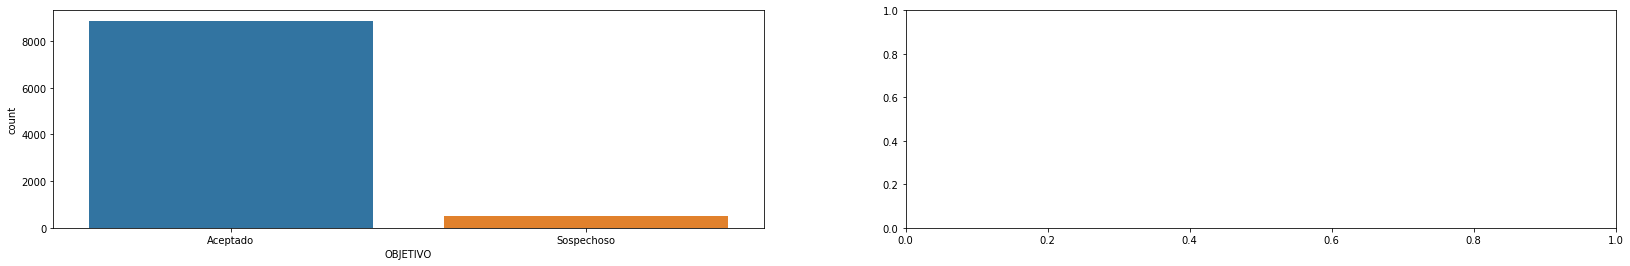

In [18]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 4))

sns.countplot(ax=axes[0], x='OBJETIVO', data=df3)

In [19]:
count_class_0, count_class_1 = df3['OBJETIVO'].value_counts()

# Divide by class
df_class_0 = df3[df3['OBJETIVO'] == 'Aceptado']
df_class_1 = df3[df3['OBJETIVO'] == 'Sospechoso']
print(count_class_0);
print(count_class_1);


8873
527


In [20]:
df_class_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8873 entries, 0 to 9399
Data columns (total 15 columns):
EFECTIVO                     8873 non-null float64
CXC                          8873 non-null float64
INVENTARIO                   8873 non-null float64
EQ_OFICINA                   8873 non-null float64
EQ_TRANSPORTE                8873 non-null float64
TERRENOS_Y_CONSTRUCCIONES    8873 non-null float64
CXP                          8873 non-null float64
ANTICIPOS_CTE                8873 non-null float64
UTILIDADES_ACUMULADAS        8873 non-null float64
UTILIDAD_O_PERDIDA           8873 non-null float64
TOTAL_VENTAS                 8873 non-null float64
TOTAL_COMPRAS                8873 non-null float64
UTILIDAD_BRUTA               8873 non-null float64
TOTAL_GASTOS                 8873 non-null float64
OBJETIVO                     8873 non-null object
dtypes: float64(14), object(1)
memory usage: 1.1+ MB


In [21]:
df_class_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 2 to 9396
Data columns (total 15 columns):
EFECTIVO                     527 non-null float64
CXC                          527 non-null float64
INVENTARIO                   527 non-null float64
EQ_OFICINA                   527 non-null float64
EQ_TRANSPORTE                527 non-null float64
TERRENOS_Y_CONSTRUCCIONES    527 non-null float64
CXP                          527 non-null float64
ANTICIPOS_CTE                527 non-null float64
UTILIDADES_ACUMULADAS        527 non-null float64
UTILIDAD_O_PERDIDA           527 non-null float64
TOTAL_VENTAS                 527 non-null float64
TOTAL_COMPRAS                527 non-null float64
UTILIDAD_BRUTA               527 non-null float64
TOTAL_GASTOS                 527 non-null float64
OBJETIVO                     527 non-null object
dtypes: float64(14), object(1)
memory usage: 65.9+ KB


Random under-sampling:
Aceptado      527
Sospechoso    527
Name: OBJETIVO, dtype: int64


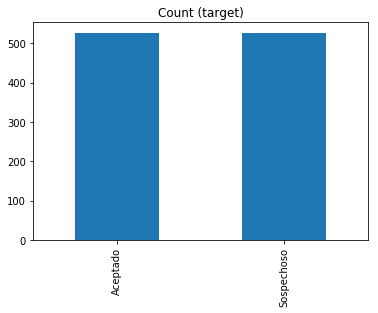

In [22]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['OBJETIVO'].value_counts())

df_test_under['OBJETIVO'].value_counts().plot(kind='bar', title='Count (target)');

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class CustomRandomUnderSampling(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        count_class_0, count_class_1 = data['OBJETIVO'].value_counts()

        # Divide by class
        df_class_0 = data[data['OBJETIVO'] == 'Aceptado']
        df_class_1 = data[data['OBJETIVO'] == 'Sospechoso']
        
        #Creamos en dataframe con data ejemplo
        df_class_0_under = df_class_0.sample(count_class_1)
        df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
        
        
        # Devolvemos un nuevo dataframe de datos
        return df_test_under

In [24]:
random_under = CustomRandomUnderSampling()
random_under.fit(X=df3)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
dfr = pd.DataFrame.from_records(
    data=random_under.transform(
        X=df3
    ),
)
 
dfr.info()
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(dfr.isnull().sum(axis = 0)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 15 columns):
EFECTIVO                     1054 non-null float64
CXC                          1054 non-null float64
INVENTARIO                   1054 non-null float64
EQ_OFICINA                   1054 non-null float64
EQ_TRANSPORTE                1054 non-null float64
TERRENOS_Y_CONSTRUCCIONES    1054 non-null float64
CXP                          1054 non-null float64
ANTICIPOS_CTE                1054 non-null float64
UTILIDADES_ACUMULADAS        1054 non-null float64
UTILIDAD_O_PERDIDA           1054 non-null float64
TOTAL_VENTAS                 1054 non-null float64
TOTAL_COMPRAS                1054 non-null float64
UTILIDAD_BRUTA               1054 non-null float64
TOTAL_GASTOS                 1054 non-null float64
OBJETIVO                     1054 non-null object
dtypes: float64(14), object(1)
memory usage: 123.6+ KB


Valores nulos en el conjunto de datos después de la transformación Simpl

In [25]:
# Definiendo las variables features y target (removed CXC and CXP)
 
features = dfr[
    [
      "CXC", 
     "CXP",
   "TERRENOS_Y_CONSTRUCCIONES",
        'EFECTIVO',
        'INVENTARIO',
       'EQ_OFICINA',
       'EQ_TRANSPORTE',        
        #'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
       # 'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',  
        'UTILIDAD_O_PERDIDA',  
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]
target = dfr["OBJETIVO"]  ## No cambie la variable target!
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)
print(f" x train {len(X_train)} , x test {len(X_test)}") 

 x train 843 , x test 211



#### Entrenando un modelo ``DecisionTreeClassifier()``

In [26]:

x_train=X_train
x_test=X_test
from sklearn.metrics import accuracy_score

# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=3)
model = dtc.fit(X_train, y_train)

predictions = dtc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

print("Exactitud: {}%".format(100*round(accuracy_score(y_test, predictions), 6)))

              precision    recall  f1-score   support

    Aceptado       0.95      0.79      0.86       104
  Sospechoso       0.82      0.96      0.89       107

    accuracy                           0.88       211
   macro avg       0.89      0.88      0.88       211
weighted avg       0.89      0.88      0.88       211

Exactitud: 87.6777%


In [27]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 15 columns):
EFECTIVO                     1054 non-null float64
CXC                          1054 non-null float64
INVENTARIO                   1054 non-null float64
EQ_OFICINA                   1054 non-null float64
EQ_TRANSPORTE                1054 non-null float64
TERRENOS_Y_CONSTRUCCIONES    1054 non-null float64
CXP                          1054 non-null float64
ANTICIPOS_CTE                1054 non-null float64
UTILIDADES_ACUMULADAS        1054 non-null float64
UTILIDAD_O_PERDIDA           1054 non-null float64
TOTAL_VENTAS                 1054 non-null float64
TOTAL_COMPRAS                1054 non-null float64
UTILIDAD_BRUTA               1054 non-null float64
TOTAL_GASTOS                 1054 non-null float64
OBJETIVO                     1054 non-null object
dtypes: float64(14), object(1)
memory usage: 123.6+ KB


              precision    recall  f1-score   support

    Aceptado       1.00      0.89      0.94       104
  Sospechoso       0.91      1.00      0.95       107

    accuracy                           0.95       211
   macro avg       0.95      0.95      0.95       211
weighted avg       0.95      0.95      0.95       211

Exactitud RandomForestClassifier: 94.7867%


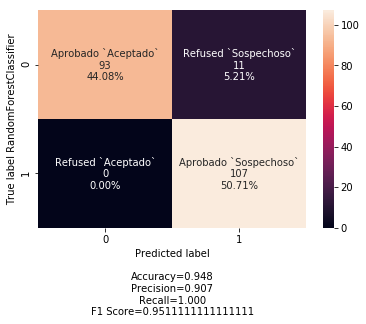

In [43]:
x_train=X_train
x_test=X_test 

from sklearn.ensemble import RandomForestClassifier
clf =RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy',max_depth=9)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(classification_report(y_test, predictions))

print("Exactitud RandomForestClassifier: {}%".format(100*round(accuracy_score(y_test, predictions), 6)))
 
    
#clf =RandomForestClassifier(n_estimators=1000, max_depth=8)   Exactitud: 92.891%
#clf =RandomForestClassifier(n_estimators=1000, max_depth=7)   Exactitud: 92.41709999999999%
#clf =RandomForestClassifier(n_estimators=100, max_depth=7)   Exactitud: 91.4692%

#clf =RandomForestClassifier(n_estimators=2000)  Exactitud: 92.891%
#clf =RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy',max_depth=9) 93.36489999999999%



y_pred = predictions

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label RandomForestClassifier')
plt.xlabel('Predicted label' + stats_text)
plt.show()
 

In [44]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-08 00:22:20--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv’

100%[======================================>] 100,124     --.-K/s   in 0.1s    

2020-09-08 00:22:21 (808 KB/s) - ‘to_be_scored_compusoluciones.csv’ saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


In [45]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
EFECTIVO                     511 non-null float64
CXC                          511 non-null float64
INVENTARIO                   511 non-null float64
EQ_OFICINA                   505 non-null float64
EQ_TRANSPORTE                513 non-null float64
TERRENOS_Y_CONSTRUCCIONES    513 non-null float64
CXP                          523 non-null float64
CONTRIBUCIONES_X_PAGAR       499 non-null float64
ANTICIPOS_CTE                515 non-null float64
CAP_SOCIAL                   504 non-null float64
UTILIDADES_ACUMULADAS        496 non-null float64
UTILIDAD_O_PERDIDA           514 non-null float64
TOTAL_VENTAS                 506 non-null float64
TOTAL_COMPRAS                527 non-null float64
UTILIDAD_BRUTA               501 non-null float64
TOTAL_GASTOS                 510 non-null float64
dtypes: float64(16)
memory usage: 75.1 KB


In [46]:
# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df_to_be_scored)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)

# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df_to_be_scored_2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_to_be_scored_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_to_be_scored_2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_to_be_scored_2.columns  # las columnas originales deben conservarse en esta transformación
)

In [47]:
df_to_be_scored_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 14 columns):
EFECTIVO                     600 non-null float64
CXC                          600 non-null float64
INVENTARIO                   600 non-null float64
EQ_OFICINA                   600 non-null float64
EQ_TRANSPORTE                600 non-null float64
TERRENOS_Y_CONSTRUCCIONES    600 non-null float64
CXP                          600 non-null float64
ANTICIPOS_CTE                600 non-null float64
UTILIDADES_ACUMULADAS        600 non-null float64
UTILIDAD_O_PERDIDA           600 non-null float64
TOTAL_VENTAS                 600 non-null float64
TOTAL_COMPRAS                600 non-null float64
UTILIDAD_BRUTA               600 non-null float64
TOTAL_GASTOS                 600 non-null float64
dtypes: float64(14)
memory usage: 65.7 KB


In [49]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = clf.predict(df_to_be_scored_3)
#se ejecutó con 
#clf =RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy',max_depth=9)

In [50]:
y_pred

array(['Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Sospechoso', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Sospechoso', 'Aceptado',
       'Aceptado', 'Aceptado', 'Sospechoso', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado', 'Aceptado',
       'Sospechoso', 'Aceptado', 'Aceptado', 'Aceptado',

In [51]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,target
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,2402813.337,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,0.000000e+00,1.858752e+06,Sospechoso
596,8.806031e+05,3.354813e+07,0.000000e+00,5.241604e+06,0.000000e+00,-1.727618e+06,4.021914e+07,3154291.078,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07,Sospechoso
597,0.000000e+00,2.711050e+07,3.260820e+06,4.681080e+06,0.000000e+00,-3.291876e+06,3.763157e+07,1861471.266,7.126997e+06,0.000,6.531900e+07,1.014415e+08,2.333685e+07,0.000000e+00,Aceptado
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,5220998.681,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07,Aceptado
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,0.000000e+00,3954071.593,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06,Aceptado


In [54]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'desafio4-donotdelete-pr-jae6jbr6bslarh',
 'asset_id': '029b33cd-4b91-4eca-b4a9-af3fda194f96'}

In [ ]:
##fin 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.948\nPrecision=0.907\nRecall=1.000\nF1 Score=0.9511111111111111')

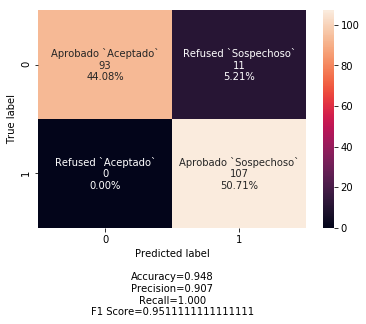

In [30]:
y_pred = predictions

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [31]:
x_train=X_train
x_test=X_test
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
dtc =GradientBoostingClassifier(n_estimators=350,learning_rate=0.01)
dtc.fit(x_train, y_train.values.ravel())
predictions = dtc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

print("Exactitud: {}%".format(100*round(accuracy_score(y_test, predictions), 6)))

              precision    recall  f1-score   support

    Aceptado       0.99      0.88      0.93       104
  Sospechoso       0.90      0.99      0.94       107

    accuracy                           0.94       211
   macro avg       0.94      0.94      0.94       211
weighted avg       0.94      0.94      0.94       211

Exactitud: 93.83890000000001%


Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.938\nPrecision=0.898\nRecall=0.991\nF1 Score=0.9422222222222222')

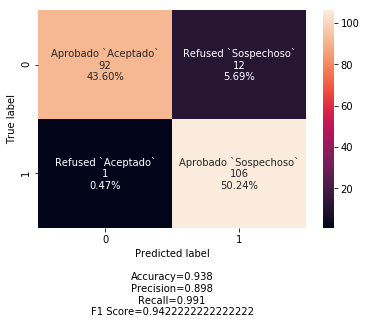

In [32]:
y_pred = predictions

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [33]:
x_train=X_train
x_test=X_test
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
dtc =GradientBoostingClassifier(n_estimators=350,learning_rate=0.1, max_depth=4, random_state=0)
dtc.fit(x_train, y_train.values.ravel())
predictions = dtc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

print("Exactitud: {}%".format(100*round(accuracy_score(y_test, predictions), 6)))
 

              precision    recall  f1-score   support

    Aceptado       0.98      0.90      0.94       104
  Sospechoso       0.91      0.98      0.95       107

    accuracy                           0.94       211
   macro avg       0.95      0.94      0.94       211
weighted avg       0.95      0.94      0.94       211

Exactitud: 94.3128%


#### Haciendo una predicción con el set de prueba

In [34]:
y_pred = dtc.predict(X_test)
print(y_pred)

['Aceptado' 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Sospechoso'
 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Sospechoso' 'Aceptado'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso'
 'Aceptado' 'Sospechoso' 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado'
 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso'
 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso'
 'Aceptado' 'Aceptado' 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso'
 'Aceptado' 'Sospechoso' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Sospechoso'
 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado' 'Aceptado' 'Aceptado'
 'Sospechoso' 'Sospechoso' 'Aceptado' 'Aceptado' 'Aceptado' 'Aceptado'
 'Aceptado' 'Aceptado' 'Aceptado' 'Aceptado' 'Aceptado' 'Aceptado'
 'Sospechoso' 'Aceptado' 'Aceptado' 'Aceptado' 'Sospechoso' 'Aceptado'
 'Aceptado' 'Aceptado' 'Aceptado' 'Sospechoso' 'Sospechoso' 'Sospechoso'
 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado' 'Sospechoso' 'Aceptado'
 'So

#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.943\nPrecision=0.913\nRecall=0.981\nF1 Score=0.9459459459459459')

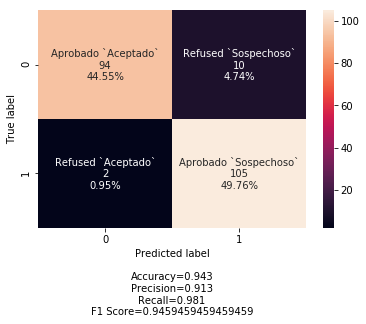

In [35]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

              precision    recall  f1-score   support

    Aceptado       0.96      0.89      0.93       104
  Sospechoso       0.90      0.96      0.93       107

    accuracy                           0.93       211
   macro avg       0.93      0.93      0.93       211
weighted avg       0.93      0.93      0.93       211

Exactitud GradientBoostingClassifier 2: 92.891%


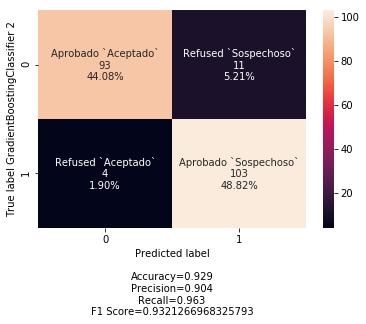

In [36]:

x_train=X_train
x_test=X_test
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
dtc=GradientBoostingClassifier(n_estimators=350,learning_rate=0.1, max_depth=5, random_state=0)
dtc.fit(x_train, y_train)
predictions = dtc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

print("Exactitud GradientBoostingClassifier 2: {}%".format(100*round(accuracy_score(y_test, predictions), 6)))



y_pred = predictions

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label GradientBoostingClassifier 2')
plt.xlabel('Predicted label' + stats_text)
plt.show()
 

In [37]:
sas

NameError: name 'sas' is not defined

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo.

<hr>

### Construcción del Pipeline completo para el encapsulamiento en WML

#### Preparando transformaciones personalizadas para cargar en WML

In [ ]:
!rm -r -f sklearn_transforms
# Susbtituya el link de abajo por el link de su repositorio git (se es necesario)
!git clone https://github.com/wmhr28/sklearn_transforms.git

In [ ]:
#!rm -r -f sklearn_transforms

En el reto 2 (Tortuga Code), se mostró cómo crear una transformación personalizada, declarando una clase Python con los métodos ``fit`` y ``transform``.

    - Código de transformación personalizada DropColumns():
    
    from sklearn.base import BaseEstimator, TransformerMixin
    # All sklearn Transforms must have the `transform` and `fit` methods
    class DropColumns(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            # Primero copiamos el dataframe de entrada 'X' de entrada
            data = X.copy()
            # Devolvemos un nuevo marco de datos sin las columnas no deseadas
            return data.drop(labels=self.columns, axis='columns')

Para integrar estos tipos de transformaciones personalizadas con Pipelines en Watson Machine Learning, primero debe empaquetar su código personalizado como una biblioteca de Python. Esto se puede hacer fácilmente usando la herramienta *setuptools*.

En el siguiente repositorio de git: https://github.com/vnderlev/sklearn_transforms tenemos todos los archivos necesarios para crear un paquete de Python, llamado **my_custom_sklearn_transforms**.
Este paquete tiene la siguiente estructura de archivos:

    /my_custom_sklearn_transforms.egg-info
        dependency_links.txt
        not-zip-safe
        PKG-INFO
        SOURCES.txt
        top_level.txt
    /my_custom_sklearn_transforms
        __init__.py
        sklearn_transformers.py
    PKG-INFO
    README.md
    setup.cfg
    setup.py
    
El archivo principal, que contendrá el código para nuestras transformaciones personalizadas, es el archivo **/my_custom_sklearn_transforms/sklearn_transformers.py**. Si accedes a él en el repositorio, notarás que contiene exactamente el mismo código declarado en el primer paso (la clase DropColumns).

Si has declarado sus propias transformaciones (además de la DropColumn proporcionada), debes agregar todas las clases de esas transformaciones creadas en este mismo archivo. Para hacer esto, debes hacer fork de este repositorio (esto se puede hacer en la propia interfaz web de Github, haciendo clic en el botón como se muestra en la imagen a continuación) y agregue sus clases personalizadas al archivo **sklearn_transformers.py**.

![alt text](https://i.imgur.com/2lZ4Ty2.png "forking-a-repo")

Si solo hizo uso de la transformación proporcionada (DropColumns), puede omitir este paso de fork y continuar usando el paquete base provisto. :)

Después de preparar su paquete de Python con sus transformaciones personalizadas, reemplace el enlace del repositorio de git en la celda a continuación y ejecútelo. Si no ha preparado ninguna transformación nueva, ejecute la celda con el enlace del repositorio ya proporcionado.

<hr>
    
**OBSERVACIÓN**

Si la ejecución de la celda a continuación devuelve un error de que el repositorio ya existe, ejecute:

**!rm -r -f sklearn_transforms**

In [ ]:
!cd sklearn_transforms
!ls -ltr

In [ ]:
 !cat sklearn_transforms/my_custom_sklearn_transforms/sklearn_transformers.py

Para subir o código no WML, precisamos enviar um arquivo .zip com todo o código fonte, então iremos zipar o diretório clonado em seguida:

In [ ]:
!zip -r sklearn_transforms.zip sklearn_transforms

Con el archivo zip de nuestro paquete cargado en el Kernel de este notebook, podemos utiliar la herramienta pip para instalarlo conforme a la siguiente celda:

In [ ]:
!pip install sklearn_transforms.zip

Ahora podemos realizar la importación de nuestro paquiete personalizado en nuestro notabook!

Vamos a importan la transformación DropColumns. Si usted posee otras transformaciones personalizadas, ahora es que debe importarlas

In [ ]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns
#from my_custom_sklearn_transforms.sklearn_transformers import CustomRandomUnderSampling

In [ ]:
df_test_under.head()

## Construyendo el model Pipeline

# ATENCIÓN, NO CAMBIE LA CELDA DE ABAJO O SU MODELO NO SERA EVALUADO

In [ ]:
count_class_0, count_class_1 = df['OBJETIVO'].value_counts()

        # Divide by class
df_class_0 = df[df['OBJETIVO'] == 'Aceptado']
df_class_1 = df[df['OBJETIVO'] == 'Sospechoso']
        
        #Creamos en dataframe con data ejemplo
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
        
pipeline_input = df_test_under[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df_test_under['OBJETIVO']

In [ ]:

# Separación de los datos en un set de entrenamiento y otro de prueba (PARA CREACION DEL PIPELINE)
X_train, X_test, y_train, y_test = train_test_split(
    pipeline_input,
    pipeline_target,
    test_size=0.3,
    random_state=21233
)
print(f" x train {len(X_train)} , x test {len(X_test)}")


In [ ]:
 df_test_under.info()

### Borrando las columnas del dataset original

Debe elminiar todas las columnas que no esta usando

In [ ]:
# Creacion de la Transformación Personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=['CXC', 'CXP']
)

### Reemplazando con zeros en lugar de valores nulos

Ud puede usar otras estrategias, pero deben ser con Transforms

In [ ]:
# Crear un objeto ``SimpleImputer``

si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='constant',  # la estrategia elegida es cambiar el valor faltante por una constante (Ejemplo)
    fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)

### Estandarizando los valores numericos

In [ ]:
sc = StandardScaler()

### Pre-entrenando el modelo para definir el pipeline

En la celda de abajo se declara un objeto **Pipeline** de scikit-learn, donde es declarado como parametros *steps*, que es una lista de etapas a ejecutar el pipeline:

    'paso_1_remove_cols'     - Transformación personalizada DropColumns
    'paso_2_imputer'         - Transformación embebida de scikit-learn para remplazar los valores faltantes
    'paso_3_standard_scaler'          - Transformación embebida de scikit-learn para escalar las variables numéricas
    'su_modelo'              - Un árbol de desición simple
    
Note que pasamos como pasos las transformaciones instanciadas anteriormente, con nombres `rm_columns` y `si`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('paso_1_remove_cols', rm_columns),
        ('paso_2_imputer', si),
        ('paso_3_standard_scaler', sc),
        #('su_modelo', GradientBoostingClassifier(n_estimators=350,learning_rate=0.1, max_depth=5, random_state=0)),
        ('su_modelo', RandomForestClassifier(n_estimators=100, random_state=0,max_depth=9)),
        
    ]
)

En seguida ejecutaremos el método `fit()` del Pipeline, realizando el pré-procesamiento y el entrenamiento del modelo de una sola vez.

In [ ]:
# Inicializando el Pipeline (pre-procesamiento y entrenamiento del modelo)
my_pipeline.fit(X_train, y_train)

In [ ]:
### Haciendo una predicción con el set de prueba

y_pred = my_pipeline.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [ ]:
# Precisión simple
my_pipeline.score(X_test, y_test)

Ahora que tenemos un Pipeline completo, con etapas de pre-procesamiento configuradas y tambien un modelo por Árbol de Desición entrenado, podemos realizar la integración con Watson Machine Learning!

<hr>

### Encapsulando un Pipeline personalizado de Watson Machine Learning

#### Estableciendo conexión entre el cliente Python de WML y su instancia del servicio en la nube

In [ ]:
# Biblioteca Python con implementación de un cliente HTTP para la API de WML
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Las próximas celdas realizaran el despliegue del pipeline declarada en este notebook en WML. Solo prosiga si usted ya está satisfecho con su modelo y cree que ya es hora de hacer el despliegue de su solución.

Copie las credenciales de su instancia de Watson Machine Learning en la variable de la celda de abajo.

Es importante que la variable que contenga los valores de la credencial se llame ``wml_credentials`` para que las proximas celdas de este notebook se ejecuten corretamente.

In [ ]:
wml_credentials = {
  "apikey": "ppizbUqztx7RWc3Y4OuPXLKQjxyNndZkpKFOVkiF-S3M",
  "iam_apikey_description": "Auto-generated for key 6b65b1ab-5c92-4925-b3b7-d7a16bda9d66",
  "iam_apikey_name": "Credenciales de servicio-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/491ab7b22a53409da27b688c6ef819fd::serviceid:ServiceId-0a79cf57-4149-4cfd-ae38-fd31be84e244",
  "instance_id": "8c800af6-7b3a-4960-b0c1-d42690cfeb07",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [ ]:
# Instanciando un objeto cliente de Watson Machine Learning a partir de las credenciales

clientWML = WatsonMachineLearningAPIClient(wml_credentials)

In [ ]:
# Extrayendo los detalles de su de Watson Machine Learning

instance_details = clientWML.service_instance.get_details()
print(json.dumps(instance_details, indent=4))

**¡¡ATENCIÓN!!**

¡Este atento de los limites de consumo de su instancia de Watson Machine Learning!

En caso de que acabe la capa gratuita, no sera posible evualuar su modelo (Pues es necesario para la realización de algunas llamadasal API con sus predicciones!)

#### Listando todos los artefatos almacenados en su WML

Para listar todos los artefatos almacenados en su Watson Machine Learning, usted puede usar la seguinte función:

    clientWML.repository.list()

In [ ]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

## ATENCIÓN!, SI UD CORRE LAS CELDAS DE ABAJO TODOS LOS DESPLIEGUES ANTERIORS SERAN BORRADOS

In [ ]:
#Celda para borrar los Deployments:

for uid in clientWML.deployments.get_uids():
    if clientWML.deployments.get_details(uid)['entity']['name'] == 'deployment_meta_4' : 
        print('Deleted ' + clientWML.deployments.get_details(uid)['entity']['name'] )
        clientWML.deployments.delete(uid)

In [ ]:
#Celda para borrar todos los recursos:

d = clientWML.repository.get_details()
for k in d:
    for res in d[k]["resources"]:
        if res['entity']['name'] in ['package_meta_4', 'runtime_meta_4', 'pipeline_meta_4']:
            clientWML.repository.delete(res["metadata"]["guid"])
            print('Deleted ' + res['entity']['name'])

In [ ]:
# Listando todos los artefatos actualmente almacenados en su instancia de WML

clientWML.repository.list()

#### Creando una nueva definición de paquete Python personalizado en WML

El primer paso para realizar su deploy y almacenar el código de las transformaciones personalizadas creadas por usted.

Para esta etapa solo necesitamos el archivo .zip del paquete creado por usted (Que ya tenemos cargados en el Kernel!)

In [ ]:
# Definición de metadatos del paquete con las Transformaciones personalizadas
pkg_meta = {
    clientWML.runtimes.LibraryMetaNames.NAME: "package_meta_4",
    clientWML.runtimes.LibraryMetaNames.DESCRIPTION: "A custom sklearn transform package",
    clientWML.runtimes.LibraryMetaNames.FILEPATH: "sklearn_transforms.zip",  # Note que estamos utilizando o .zip criado anteriormente!
    clientWML.runtimes.LibraryMetaNames.VERSION: "1.0",
    clientWML.runtimes.LibraryMetaNames.PLATFORM: { "name": "python", "versions": ["3.6"] }
}
custom_package_details = clientWML.runtimes.store_library( pkg_meta )
custom_package_uid = clientWML.runtimes.get_library_uid( custom_package_details )

print("\n Lista de artefactos de runtime almacenados en WML:")
clientWML.repository.list()

#### Creando una nueva definición de runtime Python personalizado en WML

El segundo paso es almacenar una definición de runtime Python para utilizar en nuestra biblioteca personalizada.

Esto puede hacerse de la siguiente manera:

In [ ]:
runtime_meta = {
    clientWML.runtimes.ConfigurationMetaNames.NAME: "runtime_meta_4",
    clientWML.runtimes.ConfigurationMetaNames.DESCRIPTION: "A Python runtime with custom sklearn Transforms",
    clientWML.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.6"
    },
    clientWML.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [ custom_package_uid ]
}
runtime_details = clientWML.runtimes.store( runtime_meta )
custom_runtime_uid = clientWML.runtimes.get_uid( runtime_details )

print("\n Detalles del runtime almacenados:")
print(json.dumps(runtime_details, indent=4))

In [ ]:
# Listando todos los runtimes almacenados en su WML:
clientWML.runtimes.list()

#### Creando una nueva definición de Pipeline personalizado en WML

Finalmente creando una definición (metadatos) para que nuestro Pipeline sea hospedada en WML.

Definimos como parametros el nombre para el artefacto y el ID de runtime creado anteriormente.

In [ ]:
model_meta = {
    clientWML.repository.ModelMetaNames.NAME: 'pipeline_meta_4',
    clientWML.repository.ModelMetaNames.DESCRIPTION: "my pipeline for submission",
    clientWML.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid
}

En seguida llamamos el método para almacenar una nueva definición:

In [ ]:
# Función para almacenar una definición de Pipeline en WML
stored_model_details = clientWML.repository.store_model(
    model=my_pipeline,  # `my_pipeline` es la variable creada anteriormente que contiene nuestro Pipeline ya entrenado :)
    meta_props=model_meta,  # Metadatos definidos en la celda anterior
    training_data=None  # No altere este parametro
)

print("\n Lista de artefatos almacenados en WML:")
clientWML.repository.list()

# Datalles del modelo hospedado en Watson Machine Learning
print("\n Metadatos del modelo almacenado:")
print(json.dumps(stored_model_details, indent=4))

#### Realizando un deployment de su modelo para consumo inmediato por otras aplicaciones

In [ ]:
# El deployment del modelo es finalmente realizado por medio del método ``deployments.create()``

model_deployment_details = clientWML.deployments.create(
    artifact_uid=stored_model_details["metadata"]["guid"],  # No altere este parametro
    name="deployment_meta_4",
    description="Desafio 4 MBTC",
    asynchronous=False,  # No altere este parametro
    deployment_type='online',  # No altere este parametro
    deployment_format='Core ML',  # No altere este parametro
    meta_props=model_meta  # No altere este parametro
)

#### Probando el modelo hospedado en Watson Machine Learning

In [ ]:
# Recuperando la URL endpoint dl modelo hospedado en la celda anterior

model_endpoint_url = clientWML.deployments.get_scoring_url(model_deployment_details)
print("La URL de llamada de su API es: {}".format(model_endpoint_url))

### ATENCIÓN: UD necesitará de la URL de arriba para entregar su modelo :)

In [ ]:
# Detalles del deployment realizado

deployment_details = clientWML.deployments.get_details(
    deployment_uid=model_deployment_details["metadata"]["guid"]  # Este es el ID de su deployment!
)

print("Metadatos del deployment realizado: \n")
print(json.dumps(deployment_details, indent=4))

### Realizando una llamada de API para su modelo almacenado en WML

In [ ]:
scoring_payload = {
    'fields': [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ],
    'values': [
        [
            968866.8993,
            102102.000,
            8539205.63,
            3898282.548,
            416873.3265,
            1420050.089,
            -629717.8548,
            14613560.64,
            7620711.462,
            116647.7396,
            1798064.624,
            9535423.826,
            3657339.603,
            770284.5004,
            -102101.201,
            -711032.0155
        ]
    ]
}

print("\n Payload de datos a ser clasificado:")
print(json.dumps(scoring_payload, indent=4))

In [ ]:
result = clientWML.deployments.score(
    model_endpoint_url,
    scoring_payload
)

print("\n Resultados:")
print(json.dumps(result, indent=4))

<hr>

## ¡Felicitaciones! 

Si todo fue ejecutado sin errores, ¡usted ya tiene un predictor basado en clasificacíon binaria encapsulado como una API REST!

Para enviar su solución, accede a la página:

# https://compusoluciones.maratona.dev

Usted necesitará del endpoint url de su modelo y las credenciales de WML :)